This notebook takes a trained model and evaluates it on the following metrics:
1. ECE pre and post temperature scaling
2. MCE pre and post temperature scaling
3. Test error

In [2]:
import os
import sys
cwd = os.getcwd()
module_path = "/".join(cwd.split('/')[0:-1])
if module_path not in sys.path:
    sys.path.append(module_path)
import torch
import random
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn

In [3]:
# Import dataloaders
import Data.cifar10 as cifar10
import Data.cifar100 as cifar100
import Data.tiny_imagenet as tiny_imagenet

In [4]:
# Import network architectures
from Net.resnet import resnet50, resnet110
from Net.wide_resnet import wide_resnet_cifar
from Net.densenet import densenet121
from Net.resnet_tiny_imagenet import resnet50 as resnet50_ti

In [5]:
# Import metrics to compute
from Metrics.metrics import expected_calibration_error
from Metrics.metrics import maximum_calibration_error
from Metrics.metrics import l2_error
from Metrics.plots import reliability_plot, bin_strength_plot
from Metrics.metrics import test_classification_net

In [6]:
# Dataset params

dataset_num_classes = {
    'cifar10': 10,
    'cifar100': 100,
    'tiny_imagenet': 200
}

dataset_loader = {
    'cifar10': cifar10,
    'cifar100': cifar100,
    'tiny_imagenet': tiny_imagenet
}

In [7]:
# Mapping model name to model function
models = {
    'resnet50': resnet50,
    'resnet50_ti': resnet50_ti,
    'resnet110': resnet110,
    'wide_resnet': wide_resnet_cifar,
    'densenet121': densenet121,
}

In [8]:
# Checking if GPU is available
cuda = False
if (torch.cuda.is_available()):
    cuda = True

# Setting additional parameters
torch.manual_seed(1)
device = torch.device("cuda" if cuda else "cpu")

In [9]:
class args:
    data_aug = True
    gpu = device == "cuda"
    train_batch_size = 128
    test_batch_size = 128

In [10]:
# Taking input for the dataset
print ('Enter the dataset: ')
# dataset = input()
dataset = "cifar10"
num_classes = dataset_num_classes[dataset]

if (dataset == 'tiny_imagenet'):
    print ('Enter dataset root path: ')
    dataset_root = input()
    train_loader = dataset_loader[dataset].get_data_loader(
        root=dataset_root,
        split='train',
        batch_size=args.train_batch_size,
        pin_memory=args.gpu)

    val_loader = dataset_loader[dataset].get_data_loader(
        root=dataset_root,
        split='val',
        batch_size=args.test_batch_size,
        pin_memory=args.gpu)

    test_loader = dataset_loader[dataset].get_data_loader(
        root=dataset_root,
        split='val',
        batch_size=args.test_batch_size,
        pin_memory=args.gpu)
else:
    train_loader, val_loader = dataset_loader[dataset].get_train_valid_loader(
        batch_size=args.train_batch_size,
        augment=args.data_aug,
        random_seed=1,
        pin_memory=args.gpu
    )

    test_loader = dataset_loader[dataset].get_test_loader(
        batch_size=args.test_batch_size,
        pin_memory=args.gpu
    )

Enter the dataset: 
Files already downloaded and verified
Files already downloaded and verified


Enter the model: 
Enter saved model name: 
Enter the number of bins: 
[[952   1   9   4   1   1   1   0  24   7]
 [  3 976   0   0   0   0   0   0   1  20]
 [ 12   0 917  13  17  19  15   3   2   2]
 [ 10   1   5 891  17  57   9   4   2   4]
 [  4   0   7  11 960  10   2   6   0   0]
 [  4   0   5  48  13 921   3   6   0   0]
 [  6   0   8  16   1   1 967   1   0   0]
 [  4   0   2  11  12  11   0 957   1   2]
 [ 18   2   1   3   0   0   1   0 970   5]
 [  6  13   0   5   0   0   0   0   5 971]]
Test error: 0.05179999999999996
ECE: 0.029655428653955474
MCE: 0.32843872904777527


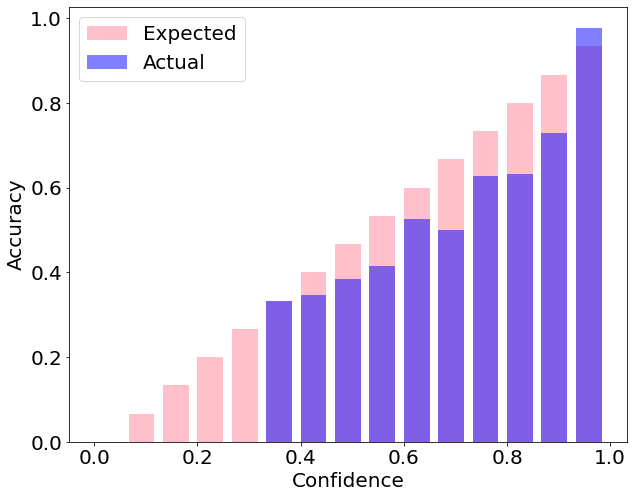

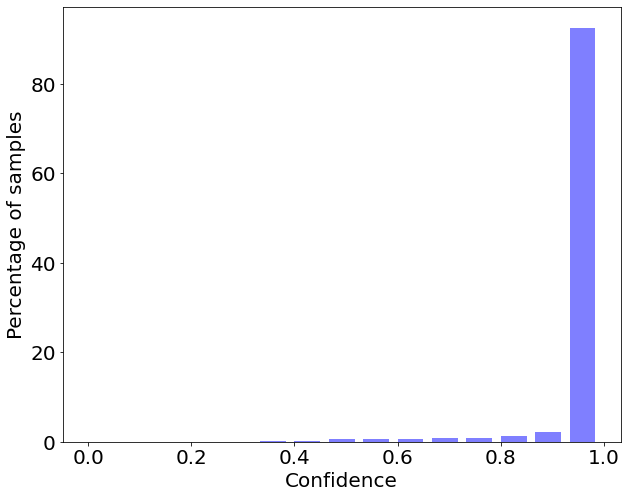

In [19]:
# Taking input for the model
print ('Enter the model: ')
# model_name = input()
model_name = "resnet50"
print ('Enter saved model name: ')
# saved_model_name = input()
saved_model_name = "/home/dylan/Desktop/progressive_fixing/run/resnet50_cifar10_cross_entropy_PF=22_WD=0.0001_220119195919/cross_entropy_300.pt"

model = models[model_name]

# Evaluating the model at T = 1
# Getting the number of bins
print ('Enter the number of bins: ')
# num_bins = int(input())
num_bins = 15

net = model(num_classes=num_classes, temp=1.0)
net.cuda()
# net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
cudnn.benchmark = True
net.load_state_dict(torch.load(str(saved_model_name)))

conf_matrix, accuracy, labels, predictions, confidences = test_classification_net(net, test_loader, device)
ece = expected_calibration_error(confidences, predictions, labels, num_bins=num_bins)
mce = maximum_calibration_error(confidences, predictions, labels, num_bins=num_bins)

# Printing the required evaluation metrics
print (conf_matrix)
print ('Test error: ' + str((1 - accuracy)))
print ('ECE: ' + str(ece))
print ('MCE: ' + str(mce))

# Plotting the reliability plot
reliability_plot(confidences, predictions, labels, num_bins=num_bins)
bin_strength_plot(confidences, predictions, labels, num_bins=num_bins)

Enter the number of bins: 
Enter the optimal temperature: 
[[953   1  11   5   5   0   1   0  18   6]
 [  0 979   0   0   0   0   0   0   2  19]
 [  6   0 942  12  10  16   7   4   3   0]
 [  8   0  12 867  13  71  12   9   2   6]
 [  2   0  11   9 961  10   3   4   0   0]
 [  2   1   6  43  14 927   3   4   0   0]
 [  4   0   4   9   3   3 974   2   0   1]
 [  1   0   2   6  10  11   0 969   0   1]
 [ 11   3   2   1   1   1   1   0 974   6]
 [  4  12   0   2   0   0   0   0   8 974]]
Test error: 0.04800000000000004
ECE: 0.03931528293490407
MCE: 0.6391960084438324


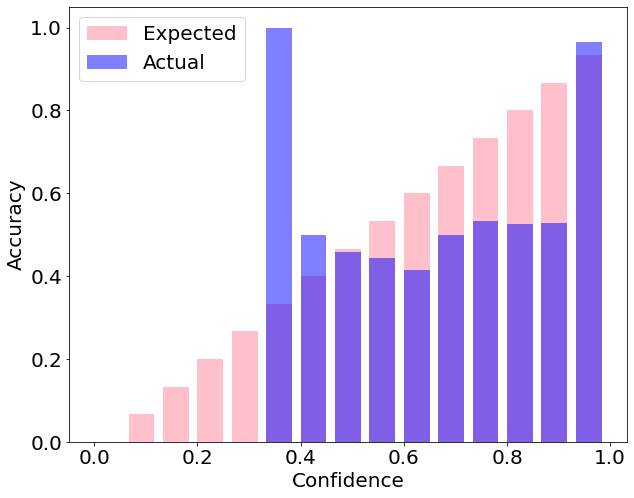

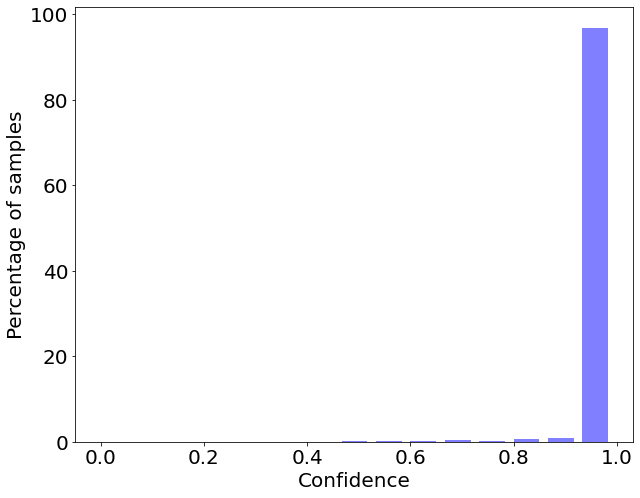

In [21]:
# Evaluating the model at T = T_opt
# Getting the number of bins
print ('Enter the number of bins: ')
# num_bins = int(input())
num_bins = 15
print ('Enter the optimal temperature: ')
t_opt = 1.1

net = model(num_classes=num_classes, temp=t_opt)
net.cuda()
# net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
cudnn.benchmark = True
net.load_state_dict(torch.load(str(saved_model_name)))

conf_matrix, accuracy, labels, predictions, confidences = test_classification_net(net, test_loader, device)
ece = expected_calibration_error(confidences, predictions, labels, num_bins=num_bins)
mce = maximum_calibration_error(confidences, predictions, labels, num_bins=num_bins)

print (conf_matrix)
print ('Test error: ' + str((1 - accuracy)))
print ('ECE: ' + str(ece))
print ('MCE: ' + str(mce))

# Plotting the reliability plot
reliability_plot(confidences, predictions, labels, num_bins=num_bins)
bin_strength_plot(confidences, predictions, labels, num_bins=num_bins)